In [ ]:
from train.training_session_v2 import load_training_session
import multiprocessing
import torch

device = "cuda"

session = load_training_session(
    save_path="saves/phase3/combining/channel_merger_269_mlp_1024_midpoint_3D/epoch_12",
    studies={
        "gwilliams2023": "audiotext",
        # "armeini2022": "audiotext"
    },  
    data_path="data",
    cache_name="/home/ubuntu/cache",
)

dataloader = session.get_dataloader(buffer_size=1, num_workers=1, max_cache_size=100, tokenize=True, add_timestamps=True)

# Unseen both
# recording = session.studies["gwilliams2023"].recordings[19][0][0]

# Seen
# recording = session.studies["gwilliams2023"].recordings[15][0][1]

# Unseen task
recording = session.studies["gwilliams2023"].recordings[18][0][0]

# Unseen subject
# recording = session.studies["gwilliams2023"].recordings[19][0][1]

# recording = session.studies["armeini2022"].recordings[0][0][0]

print(
    f"Showing recording: {recording.study_name}_{recording.subject_id}_{recording.task_id}"
)

dataloader.start_fetching(recordings=[recording])
batch = dataloader.get_recording()
(
    brain, 
    audio, 
    transcripts,
    transcript_attn_masks,
    recording,
) = (
    batch.brain_segments["all"].to(device),
    batch.audio_segments.to(device),
    batch.transcript.to(device),
    batch.transcript_attention_masks.to(device),
    batch.recording,
)

brain, audio, transcripts, transcript_attn_masks = brain[:256], audio[:256], transcripts[:256], transcript_attn_masks[:256]


conditions = {
    "study": f"{recording.study_name}",
    "subject": f"{recording.study_name}_{recording.subject_id}",
}
session.model.to(device).eval()

# with torch.no_grad():
#     (
#         x,  # [B, C, T]
#         quantizer_metrics,
#         channel_weights,
#         hidden_outputs,
#         encoder_hidden_states,  # L * [B, T, D]
#     ) = session.model(
#         x=[brain],
#         recording=[recording],
#         conditions=[conditions],
#         mel=[audio],
#         train=False,
#         return_hidden_outputs=False,
#     )

pad_len = 3000 - audio.size(2)
encoder_attention_mask = torch.zeros(
    audio.size(0), 3000, device=device
)  # [B, T]
encoder_attention_mask[:, : audio.size(2)] = 1

(
    token_ids,  # [B, T]
    x,  # [B, 80, T']
    quantizer_metrics,
    channel_weights,
    hidden_outputs,
) = session.model.generate(
    x=brain,
    recording=recording,
    conditions=conditions,
    mel=None,
    max_new_tokens=int(16 * session.config.window_size),
    attention_mask=encoder_attention_mask,
    return_hidden_outputs=False,
    return_timestamps=True
)

dataloader.stop()

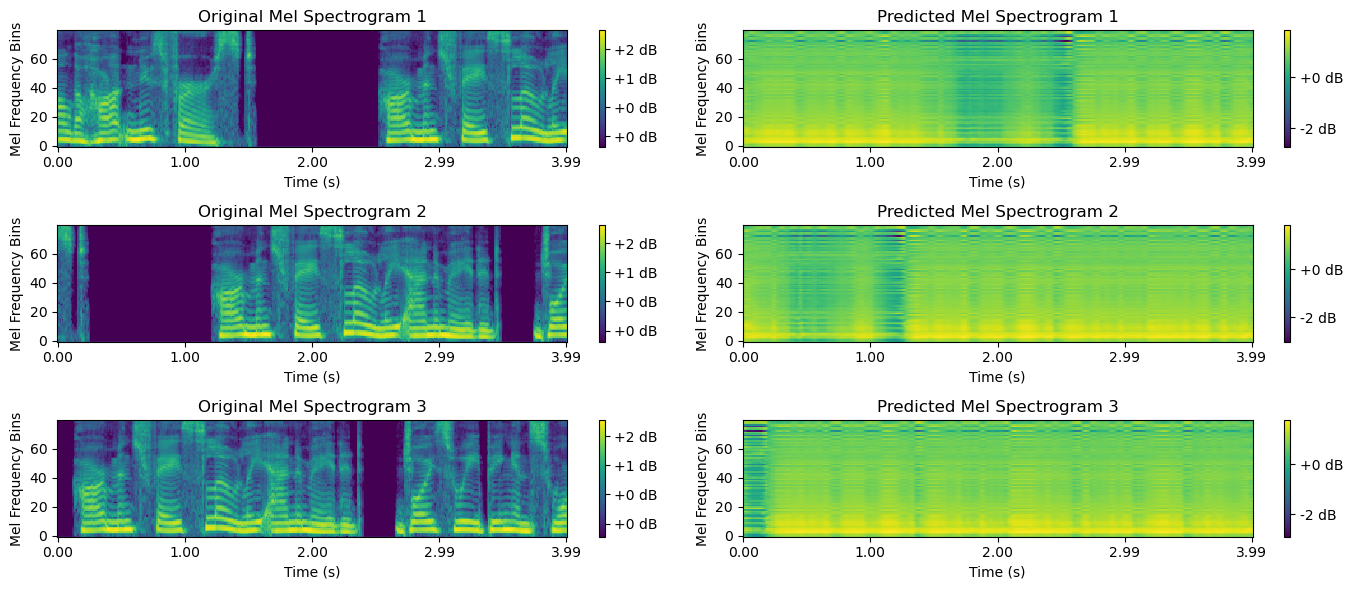

(tensor(1.8745, device='cuda:0'),
 tensor(-0.2498, device='cuda:0'),
 tensor(0.4936, device='cuda:0'),
 tensor(0.4758, device='cuda:0'),
 tensor(2.0450, device='cuda:0'),
 tensor(-3.4488, device='cuda:0'),
 tensor(0.8560, device='cuda:0'),
 tensor(0.3306, device='cuda:0'))

In [3]:
from utils.plot_mel import plot_mel_spectrogram

plot_mel_spectrogram(
    x=audio[15:18].cpu().numpy(),
    max_plots=3,
    x_pred=x[15:18].cpu().numpy(),
)
audio.max(), audio.min(), audio.mean(), audio.std(), x.max(), x.min(), x.mean(), x.std()

In [3]:
decoded_output = session.tokenizer.batch_decode(
    sequences=token_ids[15:35],
    skip_special_tokens=True,
    decode_with_timestamps=False,
    clean_up_tokenization_spaces=True,
)
# Remove extra spaces
decoded_output = [
    " ".join([w for w in sentence.split(" ") if w]) for sentence in decoded_output
]
decoded_output

['the of the the',
 'the of the the',
 'the of the the',
 'the of the the',
 'the of the the',
 'the of the the',
 'the of the the',
 'the of the the',
 'the of the the',
 'the of the the',
 'the of the the',
 'the of the of',
 'the of the the',
 'the of the of',
 'the of the the',
 'the of the the',
 'the of the of',
 'the of the the',
 'the of the the',
 'the of the the']

In [13]:
decoded_label = session.tokenizer.batch_decode(
    sequences=transcripts[15:35],
    skip_special_tokens=True,
    decode_with_timestamps=False,
    clean_up_tokenization_spaces=True,
)
decoded_label = [
    " ".join([w for w in sentence.split(" ") if w]) for sentence in decoded_label
]
decoded_label

['it was not that he felt any emotion akin to love for irene adler',
 'to love for irene adler all emotions and that',
 'adler all emotions and that one particularly',
 'and that one particularly were abhorrent to',
 'particularly were abhorrent to his cold precise but',
 'were abhorrent to his cold precise but admirably',
 'precise but admirably balanced mind he',
 'but admirably balanced mind he was i take',
 'mind he was i take it the most',
 'was i take it the most perfect reasoning and observing',
 'perfect reasoning and observing machine that the world has',
 'machine that the world has seen but as a lover',
 'has seen but as a lover he would have placed',
 'but as a lover he would have placed himself in a false position',
 'placed himself in a false position he never spoke of the',
 'he never spoke of the softer passions save with a',
 'of the softer passions save with a gibe and a sneer',
 'save with a gibe and a sneer they were admirable',
 'they were admirable things for the 

In [ ]:
for name, param in session.model.named_parameters():
    print(name, param.size())

brain_module.initial_batch_norm.weight torch.Size([208])
brain_module.initial_batch_norm.bias torch.Size([208])
brain_module.initial_linear.0.weight torch.Size([256, 208, 1])
brain_module.initial_linear.0.bias torch.Size([256])
brain_module.encoders.sequence.0.1.weight torch.Size([256, 256, 5])
brain_module.encoders.sequence.0.1.bias torch.Size([256])
brain_module.encoders.sequence.0.2.weight torch.Size([256])
brain_module.encoders.sequence.0.2.bias torch.Size([256])
brain_module.encoders.sequence.1.0.weight torch.Size([256, 256, 5])
brain_module.encoders.sequence.1.0.bias torch.Size([256])
brain_module.encoders.sequence.1.1.weight torch.Size([256])
brain_module.encoders.sequence.1.1.bias torch.Size([256])
brain_module.encoders.sequence.2.0.weight torch.Size([256, 256, 3])
brain_module.encoders.sequence.2.0.bias torch.Size([256])
brain_module.encoders.sequence.2.1.weight torch.Size([256])
brain_module.encoders.sequence.2.1.bias torch.Size([256])
brain_module.encoders.sequence.3.0.weigh

: 